# Shape descriptor analysis (Part 1b)

We finally have some numbers to work with.
- **Traditional shape descriptors**: 11 numbers, like grain length, width, height, etc
- **Topological shape descriptors**: Variable number: from the Euler Characteristic Transform

How good are these descriptors? Can we characterize the shape of different founders based solely on their grain morphology? We can train a Support Vector Machine (SVM) with an 75/25 train/test breakdown and test the classification accuracy. The SVM can be trained with either
- Purely traditional descriptors
- Purely topological descriptors
- A combination of both descriptors

Take into account that the ECT produces extremely large vectors. To avoid pathological behavior, we must reduce their dimension as a first step.

**We reduce dimension here with UMAP**

In [2]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import string
import pandas as pd
%matplotlib inline
import os

import umap

In [1]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

## Read and wrangle the data

- Read the CSV that contains both the traditional and topological descriptors
- For the topological descriptors, we select the file corresponding to the number of directions `d` and thresholds `T`
- Get the name of founders and shorten some of their names (it will make plots less clustered later)
- Distinguish the columns referring to traditional or topological information

In [3]:
src = '../../preproc/norm_ect/results/'

d = 158
T = 16

kernel = 'umap'
combined_file = '{}combined_d{}_T{}.csv'.format(src, d, T)
data = pd.read_csv(combined_file)
print(data.shape)
data.head()

(3121, 2548)


,Scan,Color,Generation,Selection,Progeny,Label (C-G-S-P),Founder,Label,Tag,Length,...,10075,10079,10083,10087,10091,10095,10099,10103,10107,10111
0,S005,Red,0,5,19,R-48-5-19,Atlas,2,seed_10_0,82.15945,...,-5,2,1,1,1,1,1,1,1,1
1,S005,Red,0,5,19,R-48-5-19,Atlas,2,seed_24_0,77.96905,...,0,1,1,1,1,1,1,1,1,1
2,S005,Red,0,5,19,R-48-5-19,Atlas,2,seed_20_0,73.92173,...,2,1,1,1,1,1,1,1,1,1
3,S005,Red,0,5,19,R-48-5-19,Atlas,2,seed_11_0,79.44825,...,0,1,1,1,1,1,1,1,1,1
4,S005,Red,0,5,19,R-48-5-19,Atlas,2,seed_9_0,81.29421,...,6,0,1,1,1,1,1,1,1,1


- Get accession names

In [4]:
founder_names = np.unique(data.Founder.dropna().values)
print(founder_names)

['Algerian' 'Alpha' 'Arequipa' 'Atlas' 'California Mariout (81A)'
 'Club Mariout' 'Everest' 'Flynn' 'Glabron' 'Golden Pheasant'
 'Good Delta (104)' 'Han River' 'Hannchen' 'Horn' 'Lion' 'Lyallpur'
 'Maison Carree (Carre 42)' 'Manchuria' 'Meloy' 'Minia' 'Multan'
 'Oderbrucker' 'Orel' 'Palmella Blue (79B)' 'Sandrel' 'Trebi'
 'White Smyrna' 'Wisconsin Winter']


- Determine which colums correspond to traditional, topological, or meta-information

In [5]:
foo = list(data.columns[:8])
foo.append('Tag')

meta_traits = pd.Index(foo)
trad_traits = data.columns[9:20]
topo_traits = data.columns[20:]

print(meta_traits, trad_traits, topo_traits, sep='\n')

Index(['Scan', 'Color', 'Generation', 'Selection', 'Progeny',
       'Label (C-G-S-P)', 'Founder', 'Label', 'Tag'],
      dtype='object')
Index(['Length', 'Width', 'Height', 'HeightMax', 'Shell', 'Area', 'Vol',
       'ConvexArea', 'ConvexVol', 'ConvexAreaRatio', 'ConvexVolRatio'],
      dtype='object')
Index(['3', '7', '11', '15', '19', '23', '27', '31', '35', '39',
       ...
       '10075', '10079', '10083', '10087', '10091', '10095', '10099', '10103',
       '10107', '10111'],
      dtype='object', length=2528)


In [6]:
ect_founders = data[topo_traits]
trad_founders = data[trad_traits]
print(ect_founders.shape, sep='\n')
ect_founders.head()

(3121, 2528)


,3,7,11,15,19,23,27,31,35,39,...,10075,10079,10083,10087,10091,10095,10099,10103,10107,10111
0,8,-3,5,10,-3,1,1,1,1,1,...,-5,2,1,1,1,1,1,1,1,1
1,1,-1,-3,2,5,-1,1,1,1,1,...,0,1,1,1,1,1,1,1,1,1
2,11,-1,1,2,1,0,1,1,1,1,...,2,1,1,1,1,1,1,1,1,1
3,1,6,-4,3,-3,1,1,1,1,1,...,0,1,1,1,1,1,1,1,1,1
4,19,5,15,9,0,1,1,1,1,1,...,6,0,1,1,1,1,1,1,1,1


## UMAP dimension reduction

- [Uniform Manifold Approximation and Projection (UMAP)](https://arxiv.org/abs/1802.03426v1) draws several ideas from TDA. 

- Intuitively, UMAP seeks to project the high-dimensional data unto a low-dimensional space while preserving the most prominent topological and geometrical features. 

- If the original data contains large connected components, wide loops, and ample voids, its low-dimensional UMAP projection should also exhibit several connected components, loops, and voids. 

- If two sample points are close to each other in the high-dimensional space, these two should remain close when projected to the low-dimensional space; similarly, distant points in the high-dimensional space are forced to remain distant in the low-dimensional space as well.

- The [official UMAP-python implementation](umap-learn.readthedocs.io/) has very well written documentation, with plenty of examples and friendliness.

In [8]:
umap_params = {'n_neighbors':50, 'min_dist':0.1, 'n_components':2, 'metric':'manhattan'}
umap_trans = umap.UMAP(**umap_params).fit(ect_founders.values)
u_founders = umap_trans.transform(ect_founders.values)

### Plot the first two UMAP components

../preproc/norm_ect/ssumap/umap_158_16_50_0.1_2_manhattan_unsupervised.jpg


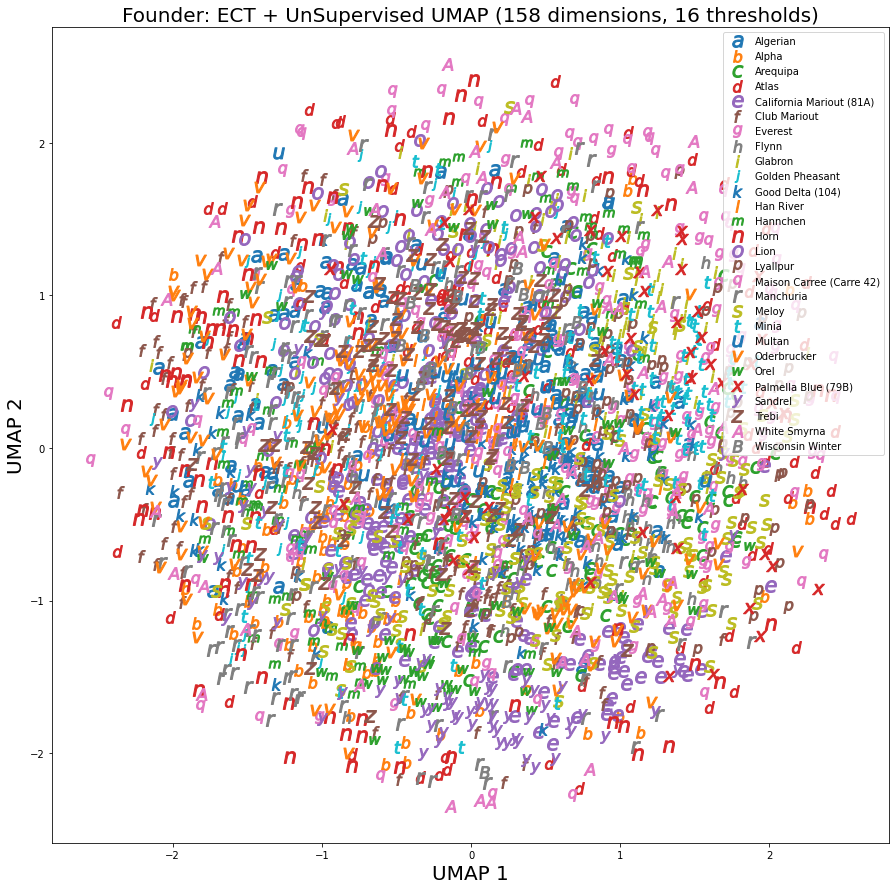

In [9]:
df = pd.DataFrame(u_founders[:,:2] - np.mean(u_founders[:,:2], axis=0), columns=['x', 'y'])
df['Founder'] = data.Founder.values
groups = df.groupby('Founder')
fs = 20

plt.figure(figsize=(15,15))
for i, foo in enumerate(groups):
    name, group = foo
    plt.plot(group.x, group.y, marker='${}$'.format(string.ascii_letters[i]), linestyle='', 
             markersize=12, label=name)
    #plt.xlim(-3,2); plt.ylim(-3, 2)
plt.legend();

plt.xlabel('UMAP 1', fontsize=fs)
plt.ylabel('UMAP 2', fontsize=fs)
plt.title('Founder: ECT + UnSupervised UMAP ({} dimensions, {} thresholds)'.format(d,T), fontsize=fs)

dst = '../preproc/norm_ect/umap/'
filename = dst + 'umap_{}_{}_{}_{}_{}_{}_unsupervised.jpg'.format(d, T, *umap_params.values())
print(filename)
#plt.savefig(filename, dpi=100, bbox_inches='tight', pil_kwargs={'optimize':True})

## Save the UMAP dimension reduction

In [10]:
dst = '../../preproc/norm_ect/umap/'
filename = dst + 'umap_topological_{}_{}_{}_{}_{}_{}_supervised.csv'.format(d, T, *umap_params.values())
print(filename)
np.savetxt(filename, u_founders, delimiter=',', fmt='%.5f')

../../preproc/norm_ect/umap/umap_topological_158_16_50_0.1_2_manhattan_supervised.csv


# SVM classification with sklearn

- Scale the data so it has mean 0 and variance 1.
- Split every accession into 75/25 training/testing

In [11]:
topo_scaler = StandardScaler(with_std=True)
trad_scaler = StandardScaler()

topo_founders_scaled = topo_scaler.fit_transform(u_founders)
trad_founders_scaled = trad_scaler.fit_transform(trad_founders)

scaled_founders_data = np.column_stack((trad_founders_scaled, topo_founders_scaled))
scaled_founders_data.shape

(3121, 13)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(topo_founders_scaled,
                                                    data.Founder.values,
                                                    stratify=data.Founder.values,
                                                    test_size=0.25)

In [13]:
svm_params = {'C':50, 'kernel':'rbf', 'gamma':0.1}
svc = SVC(**svm_params).fit(X_train, y_train)
print(svc.score(X_test, y_test))

0.22023047375160051


### Repeat SVM classification 100 times

- Unlike KPCA, each UMAP component is slightly different depending on the dimension reduction.

- In other words, the first two UMAP principal components when doing a 24-dimensional reduction are **different** than whenever doing a 3-dimensional reduction.

- Loop through all dimensions to reduce to.

- Compute UMAP every time and save the result for future use.

- Perform 100 random SVM classification tasks.


- The loop below can be modified so that we use either combined or topological shape descriptors

In [ ]:
N = len(founder_names)
reps = 100
dst = '../preproc/norm_ect/umap/'
info_type = 'Combined'
svm_params = {'C':50, 'kernel':'rbf', 'gamma':0.1}

for dims in [2,3,6,12]:
    umap_params = {'n_neighbors':50, 'min_dist':0.1, 'n_components':dims, 'metric':'manhattan'}
    filename = dst + 'umap_{}_{}_{}_{}_{}_{}_unsupervised.csv'.format(d, T, *umap_params.values())
    
    if os.path.isfile(filename):
        u_founders = np.loadtxt(filename, delimiter=',')
    else:
        umap_trans = umap.UMAP(**umap_params).fit(ect_founders.values)
        u_founders = umap_trans.transform(ect_founders.values)
        np.savetxt(filename, u_founders, delimiter=',', fmt='%.5f')
    
    topo_scaler = StandardScaler(with_std=True)
    trad_scaler = StandardScaler()

    topo_founders_scaled = topo_scaler.fit_transform(u_founders)
    trad_founders_scaled = trad_scaler.fit_transform(trad_founders)

    scaled_founders_data = np.column_stack((trad_founders_scaled, topo_founders_scaled))
    confusion = np.zeros((reps*N, N), dtype=int)

    for i in range(reps):
        X_train, X_test, y_train, y_test = train_test_split(scaled_founders_data,
                                                        data.Founder.values,
                                                        stratify=data.Founder.values,
                                                        test_size=0.25)
        svc = SVC(**svm_params).fit(X_train, y_train)
        confusion[i*N:(i+1)*N,:] = confusion_matrix(y_test, svc.predict(X_test))

    filename = dst + 'svm_results_{}_{}_{}_{}_{}_founders.npy'.format(info_type.lower(), d, T, kernel, dims)
    np.save(filename, confusion)